# Modified from Text Analytics with Python

# Gensim is a super fast library to create feature vectors (embeddings) from text  -- https://radimrehurek.com/gensim/index.html

# First, let's load a pretrained deep learning model: Word2Vec

In [1]:
import gensim.downloader as api
word2vecA = api.load('word2vec-google-news-300')

### The model aims at assigning nearby feature vectors to similar words, allowing linear operations such as:  

In [2]:
# W1 and W2 should be embeddings near each other: W1 ~= W2
W1 = word2vecA["king"] - word2vecA["man"] + word2vecA["woman"]
W2 = word2vecA["queen"]
# You can find that by 
print(word2vecA.most_similar(positive=["king", "woman"], negative=["man"], topn=1))
# Or you can also verify that by searching the two closest words to W1
print(word2vecA.most_similar(positive=[W1], topn=2))

[('queen', 0.7118193507194519)]
[('king', 0.8449392318725586), ('queen', 0.7300518155097961)]


# Second, let's import required packages and use a corpus to train our own model

In [3]:
import re
import nltk
import numpy as np
from   nltk.corpus import gutenberg, stopwords
from   string      import punctuation
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline

wpt        = nltk.WordPunctTokenizer()
stop_words = stopwords.words('english') # define stopwords

# Create a standard function to normalize documents. It will be used to normalize your own corpus later

def normalize_document(doc): 
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

# convert to lower case and remove punctuation and digits
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
# apply your standard function for document normalization, and then 
# eliminate sentences with less than two tokens
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])


Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


# Train your Word2Vec model on the selected corpus

In [4]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

# tokenize sentences in corpus
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size   = 300  # embedding dimensionality  
window_context = 30   # context window size: 15 words around the central word                                                                                    
min_word_count = 3    # minimum word count: consider the word when it appears at least 3 times in the corpus      
num_cores      = 12   # number of processors in your machine to speed up process if you have cython 

word2vecB      = Word2Vec(sentences=tokenized_corpus, vector_size=feature_size, window=window_context, \
                          min_count=min_word_count, epochs=50, workers=num_cores)


In [5]:
# create a dictionary with some similar words based on gensim's model
similar_words = {search_term: [item[0] for item in word2vecB.wv.most_similar([search_term], topn=5)]
                for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'god': ['glory', 'salvation', 'sworn', 'covenant', 'godly'],
 'jesus': ['peter', 'repentance', 'apostles', 'immediately', 'john'],
 'noah': ['shem', 'japheth', 'ham', 'methuselah', 'lamech'],
 'egypt': ['egyptians', 'pharaoh', 'bondage', 'lice', 'flowing'],
 'john': ['baptist', 'james', 'peter', 'galilee', 'baptize'],
 'gospel': ['christ', 'sufferings', 'godly', 'preach', 'saints'],
 'moses': ['aaron', 'joshua', 'sinai', 'ordinance', 'congregation'],
 'famine': ['pestilence', 'blasting', 'mildew', 'sojourn', 'deaths']}

## The same operations now produce different results, due to the change of context

In [6]:
# W1 and W2 should be embeddings near each other: W1 ~= W2
W1 = word2vecB.wv["king"] - word2vecB.wv["man"] + word2vecB.wv["woman"]
W2 = word2vecB.wv["queen"]
# You can find that by 
print(word2vecB.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=1))
# Or you can also verify that by searching the two closest words to W1
print(word2vecB.wv.most_similar(positive=[W1], topn=2))

[('rabbah', 0.2815967798233032)]
[('woman', 0.6428095102310181), ('king', 0.5842264294624329)]


## Visualize word embeddings

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


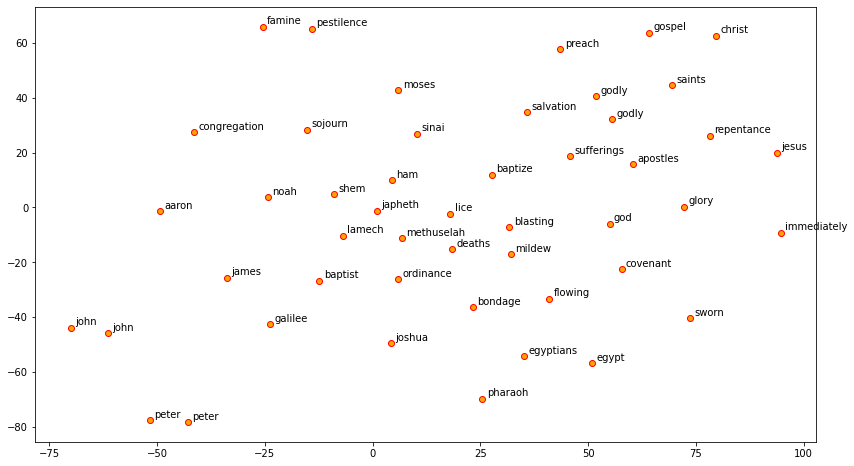

In [7]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = word2vecB.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=10)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# Create your own corpus 

In [8]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
print(corpus_df)

                                                             Document Category
0                                      The sky is blue and beautiful.  weather
1                                   Love this blue and beautiful sky!  weather
2                        The quick brown fox jumps over the lazy dog.  animals
3  A king's breakfast has sausages, ham, bacon, eggs, toast and beans     food
4                         I love green eggs, ham, sausages and bacon!     food
5                    The brown fox is quick and the blue dog is lazy!  animals
6            The sky is very blue and the sky is very beautiful today  weather
7                         The dog is lazy but the brown fox is quick!  animals


# Preprocess it 

In [9]:
norm_corpus = normalize_corpus(corpus)
print(norm_corpus)

['sky blue beautiful' 'love blue beautiful sky'
 'quick brown fox jumps lazy dog'
 'kings breakfast sausages ham bacon eggs toast beans'
 'love green eggs ham sausages bacon' 'brown fox quick blue dog lazy'
 'sky blue sky beautiful today' 'dog lazy brown fox quick']


## Train a Word2Vec model on your sample corpus

In [10]:
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size   = 10  # embedding dimensionality  
window_context = 3   # context window size: 1 word around the central word                                                                                    
min_word_count = 1   # minimum word count: consider the word when it appears at least 1 time in the corpus      
num_cores      = 12  # number of processors in your machine to speed up process if you have cython 

word2vecC      = Word2Vec(sentences=tokenized_corpus, vector_size=feature_size, window=window_context, \
                          min_count=min_word_count, epochs=100, workers=num_cores)


In [11]:
# create a dictionary with some similar words
similar_words = {search_term: [item[0] for item in word2vecC.wv.most_similar([search_term], topn=3)]
                for search_term in ['sky', 'fox', 'breakfast']}
similar_words

{'sky': ['blue', 'bacon', 'sausages'],
 'fox': ['quick', 'today', 'love'],
 'breakfast': ['green', 'kings', 'love']}

## Visualize word embeddings

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


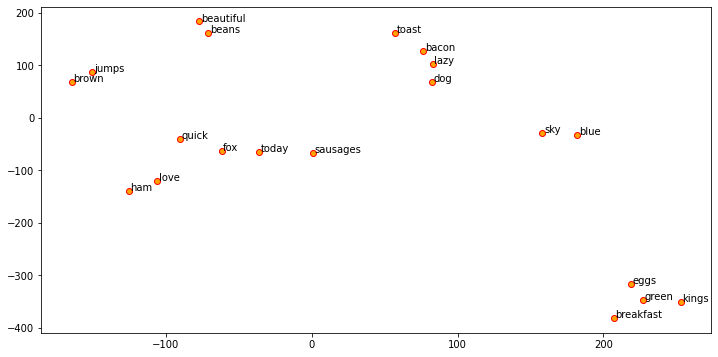

In [12]:
words = word2vecC.wv.index_to_key
wvs   = word2vecC.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Sample word embedding

In [13]:
word2vecC.wv['sky']

array([-0.00650653,  0.00165769,  0.05251156,  0.09033262, -0.09172861,
       -0.07161501,  0.06707988,  0.09047023, -0.05170376, -0.03739343],
      dtype=float32)

## Build framework for getting document (sentence) level embeddings

In [14]:
# Average of the word vectors of a given sentence

def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
# Compute the embedding of each sentence in a corpus as the average of its word embeddings    
def Doc2Vec(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    #print(vocabulary)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) \
                for tokenized_sentence in corpus]
    return np.array(features)

In [15]:
w2v_feature_array = Doc2Vec(corpus=tokenized_corpus, model=word2vecC, num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9
0,-0.003058,-0.008641,0.035086,0.027984,-0.053435,-0.036183,0.060932,0.014549,-0.045775,-0.059238
1,0.003382,-0.018292,0.047592,-0.003435,-0.022776,-0.019782,0.034021,0.022211,-0.039022,-0.027430
2,-0.026250,0.043631,-0.026681,-0.041218,0.037346,0.000333,0.018762,0.013306,-0.007740,0.025239
3,-0.006139,-0.025693,0.013477,0.019014,0.023917,0.013165,0.018590,-0.005417,0.010433,0.013170
4,0.001664,-0.029173,0.029612,0.024028,0.037718,0.032967,0.019836,0.023164,-0.020708,0.036433
5,0.000229,0.035499,-0.026354,-0.021669,0.023457,-0.011599,0.010943,0.024727,-0.034063,-0.001417
6,-0.001069,-0.008166,0.036277,0.019190,-0.055612,-0.030766,0.061074,0.022239,-0.057121,-0.033951
7,-0.014345,0.045987,-0.022765,-0.039259,0.037476,-0.010353,0.006809,0.027462,-0.024049,0.016994


## Clustering with sentence embeddings

In [16]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,1
7,The dog is lazy but the brown fox is quick!,animals,2


## Visualize the PCA projection of the sentences in each cluster 

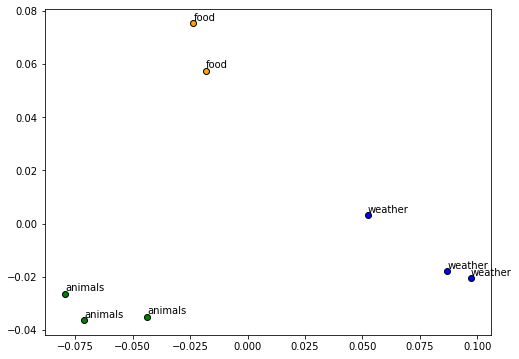

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

## GloVe Embeddings with spaCy

## First, load a vocabulary with word embeddings created by GloVe

In [18]:
import spacy

# make sure you have a GloVe pretrained model for an english vocabulary by downloading en_vectors_web_md   
!python -m spacy download en_core_web_md

nlp = spacy.load("en_core_web_md") # load the pipeline with the pretrained model

total_vectors = len(nlp.vocab.vectors)
print('Total of word vectors:', total_vectors)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 6.2 MB/s eta 0:00:000m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
Total of word vectors: 20000


In [19]:
# You can parse any sentence and get its word embeddings

parsed_text = nlp("The green frog jumped the black dog")

glove_vectors = [w.vector for w in parsed_text]
for i, w in enumerate(parsed_text):
    print(w, glove_vectors[i])

The [-0.65276     0.23873    -0.23325     0.18608     0.37674    -0.054116
 -0.19189     0.22731    -0.092528    1.8388     -0.18715    -0.22237
  0.31873     0.11472     0.38304     0.20092    -0.27932     2.3462
 -0.39846    -0.19525    -0.25649     0.25508     0.094618   -0.41082
 -0.34191    -0.19499     0.17814     0.0053463  -0.47565     0.28022
 -0.2192      0.60433     0.29309    -0.24232     0.527       0.39024
 -0.56955     0.3762     -0.23126    -0.29921     0.045643    0.14555
  0.14231     0.10587     0.4121     -0.25261    -0.03209    -0.5283
 -0.026925    0.26227     0.16375     0.099259    0.31664    -0.1104
  0.25732    -0.4072     -0.069903   -0.13189    -0.55753    -0.14815
 -0.33673    -0.36122     0.021905    0.68589    -0.080151   -0.12327
 -0.050595   -0.13694     0.27306    -0.14885     0.004515    0.16709
  0.088148   -0.1748     -0.12441     0.056394    0.14228     0.36865
  0.059486   -0.19471    -0.25575     0.22853    -0.0082876   0.020285
  0.42212     0.1

## Visualize GloVe word embeddings of our corpus

In [20]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
ham,-0.77332,-0.282540,0.580760,0.841480,0.258540,0.585210,-0.021890,-0.463680,0.139070,0.65872,...,0.464470,0.481400,-0.829200,0.354910,0.224530,-0.493920,0.456930,-0.649100,-0.131930,0.372040
lazy,-0.99977,-0.194700,-0.419580,-0.057033,-0.269880,0.157750,0.262730,-0.600500,0.142440,1.90950,...,-0.004007,0.103060,-0.290390,-0.443710,0.291390,0.562800,0.007213,0.447610,0.029474,0.225460
fox,-0.65300,0.313580,0.272250,0.168970,-0.141280,-0.082146,-0.223320,0.072920,0.116300,0.29846,...,0.459840,0.469450,-0.700100,-0.214730,0.221710,-0.898330,-0.057084,-0.562940,-0.358810,0.378860
brown,-0.66906,-0.351330,0.080640,0.096664,-0.148040,-0.097573,0.243160,0.094992,0.582290,0.17268,...,0.412470,0.400660,-0.324850,-0.765130,-0.232630,-0.191630,0.230500,-0.637830,0.314030,0.203840
eggs,-0.61023,-0.231630,-0.233030,-0.406420,-0.003735,0.865060,-0.140390,0.009982,-0.018391,1.49490,...,0.052207,-0.581650,-0.410380,0.081747,-0.596170,0.210670,-0.064823,-0.164010,0.002626,0.417920
dog,-0.72483,0.425380,0.025489,-0.398070,0.037463,-0.298110,-0.282790,0.293330,0.577750,1.22050,...,0.019095,-0.342830,-0.586020,0.009563,-0.085052,0.833120,0.319780,0.050317,-0.231590,0.281650
blue,-0.60781,-0.442570,-0.188280,0.298840,0.213040,-0.251680,-0.766230,0.261160,-0.104190,1.08480,...,-0.264490,0.252610,0.322410,-0.030879,-0.186760,0.795420,-0.512570,0.124920,0.373600,0.349780
jumps,-0.60320,0.096645,-0.272320,0.150660,-0.039076,-0.131000,-0.256660,-0.025637,0.435760,1.60800,...,0.191720,-0.193110,-0.149160,-0.055604,-0.346140,0.193340,0.074380,-0.177050,0.214030,-0.193550
beautiful,-0.60053,0.188380,-0.409930,0.322500,0.070322,0.161760,0.369450,-0.412770,-0.039160,2.22850,...,-0.307520,0.181140,0.021235,0.127830,0.352920,0.581560,0.362820,-0.277990,0.312290,-0.283310
green,-0.81745,0.134040,0.233550,-0.273360,-0.136910,0.943380,-0.103160,0.211570,-0.582040,0.68200,...,0.284830,0.079486,-0.163030,-0.289800,-0.751070,0.292390,0.154300,-0.857900,0.366390,0.060845


/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


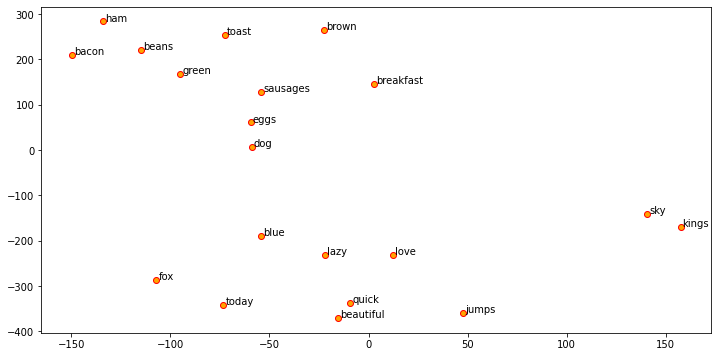

In [21]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Cluster documents with GloVe Embeddings

In [22]:
from sklearn.cluster import KMeans 

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


# Leveraging gensim for building a FastText model

In [ ]:
from gensim.models.fasttext import FastText 


tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size   = 300 # Word vector dimensionality  
window_context = 30  # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
num_cores      = 12  # Number of processors

# train the model 
fast_text = FastText(tokenized_corpus, vector_size=feature_size, window=window_context, 
                    min_count=min_word_count, workers=num_cores, epochs=50) # it does not support n-grams with n
                                                                            # different than 1


In [ ]:
# view similar words based on the fast_text model
similar_words = {search_term: [item[0] for item in fast_text.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

### Visualize their projection by PCA

In [ ]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = fast_text.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

### Playing with similarity

In [ ]:
fast_text.wv['jesus']

In [ ]:
print(fast_text.wv.similarity(w1='god', w2='satan'))
print(fast_text.wv.similarity(w1='god', w2='jesus'))

In [ ]:
st1 = "christ jesus satan gospel"
print('Odd one out for [',st1, ']:', fast_text.wv.doesnt_match(st1.split()))

st2 = "john peter james judas"
print('Odd one out for [',st2, ']:', fast_text.wv.doesnt_match(st2.split()))